In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

Data Preprocessing

In [25]:
df = pd.read_csv("Data-Historis-BMRI-Monthly.csv")
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,11/01/2025,"4,730","4,720","4,790","4,680",308.12M,0.21%
1,10/01/2025,"4,720","4,360","4,830","4,010",4.36B,7.27%
2,09/01/2025,"4,400","4,550","4,750","4,310",3.89B,-6.98%
3,08/01/2025,"4,730","4,570","4,980","4,510",2.97B,4.88%
4,07/01/2025,"4,510","4,900","4,990","4,510",3.87B,-7.58%


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      24 non-null     object
 1   Price     24 non-null     object
 2   Open      24 non-null     object
 3   High      24 non-null     object
 4   Low       24 non-null     object
 5   Vol.      24 non-null     object
 6   Change %  24 non-null     object
dtypes: object(7)
memory usage: 1.4+ KB


In [30]:
# clean volume colume ( delete B)
df['Vol.'] = df['Vol.'].str.replace('B', '', regex=False)
df['Vol.'] = df['Vol.'].str.replace('M', '', regex=False)
df['Vol.'] = df['Vol.'].str.replace('.', '', regex=False)
df['Vol.'] = df['Vol.'].str.replace(',', '.', regex=False)
df['Vol.'] = df['Vol.'].astype(float)

# clean changable volume% (hapus '%' dan ubah ke float)
df['Change%'] = df['Change%'].str.replace('%', '', regex=False)
df['Change%'] = df['Change%'].str.replace(',', '.', regex=False)
df['Change%'] = df['Change%'].astype(float)

# change date column
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce', dayfirst=True)

df = df.dropna(subset=['Date'])
df = df.sort_values('Date').reset_index(drop=True)
df = df.set_index('Date')

print(df.dtypes)
print(df.head())

AttributeError: Can only use .str accessor with string values!

In [ ]:
print("First date in data:", df.index[0])
print("Last date in data:", df.index[-1])

First date in data: 2023-11-01 00:00:00
Last date in data: 2025-10-01 00:00:00


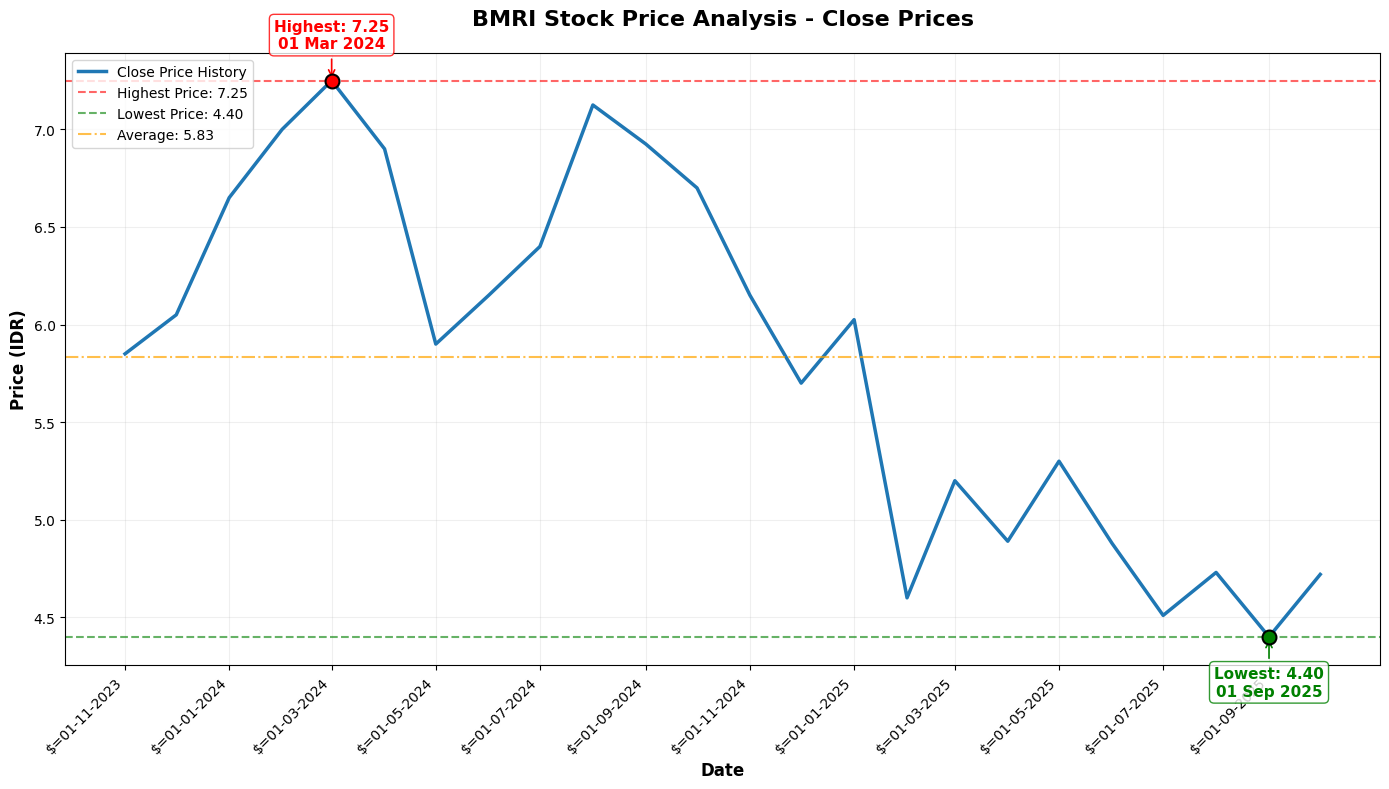

In [ ]:
# Close price visualitation

plt.figure(figsize=(14, 8))

plt.plot(df.index, df['Terakhir'], label='Close Price History', color='#1f77b4', linewidth=2.5)

# calculate highest and lowest prices
max_price = df['Terakhir'].max()
min_price = df['Terakhir'].min()
max_price_idx = df['Terakhir'].idxmax()
min_price_idx = df['Terakhir'].idxmin()

# get the corresponding dates
max_date = max_price_idx
min_date = min_price_idx

# Highlight the highest price point
plt.scatter(max_price_idx, max_price, color='red', s=100,
      zorder=5, edgecolors='black', linewidth=1.5)
plt.annotate(f'Highest: {max_price:.2f}\n{max_date.strftime("%d %b %Y")}',
      xy =(max_price_idx, max_price),
      xytext=(max_price_idx, max_price + 0.15),
      fontsize=11, color='red', fontweight='bold',
      ha='center', va='bottom',
      bbox=dict(boxstyle='round,pad=0.3', facecolor=
      'white', alpha=0.8, edgecolor='red'),
      arrowprops=dict(arrowstyle='->', color='red',
      lw=1.2))

# Highlight the lowest price point
plt.scatter(min_price_idx, min_price, color='green', s=100,
      zorder=5, edgecolors='black', linewidth=1.5)
plt.annotate(f'Lowest: {min_price:.2f}\n{min_date.strftime("%d %b %Y")}',
      xy=(min_price_idx, min_price),
      xytext=(min_price_idx, min_price - 0.15),
      fontsize=11, color='green', fontweight='bold',
       ha='center', va='top',
       bbox=dict(boxstyle='round,pad=0.3', facecolor=
      'white', alpha=0.8, edgecolor='green'),
      arrowprops=dict(arrowstyle='->', color='green',
      lw=1.2))

# Add horizontal lines for min and max prices
plt.axhline(max_price, linestyle='--', color='red', alpha=
      0.6, label=f'Highest Price: {max_price:.2f}')
plt.axhline(min_price, linestyle='--', color='green', alpha=
      0.6, label=f'Lowest Price: {min_price:.2f}')

# Calculate and display the average price
avg_price = df['Terakhir'].mean()
plt.axhline(avg_price, linestyle='-.', color='orange',
      alpha=0.7, label=f'Average: {avg_price:.2f}')

# Style the chart
plt.title('BMRI Stock Price Analysis - Close Prices',
      fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Price (IDR)', fontsize=12, fontweight='bold')

# Format x-axis with dates
date_labels = [i.strftime('$=%d-%m-%Y') for i in df.index]
plt.xticks(df.index[::2], date_labels[::2], rotation=45, ha=
      'right', fontsize=10)

plt.grid(True, linestyle='-', alpha=0.2)
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

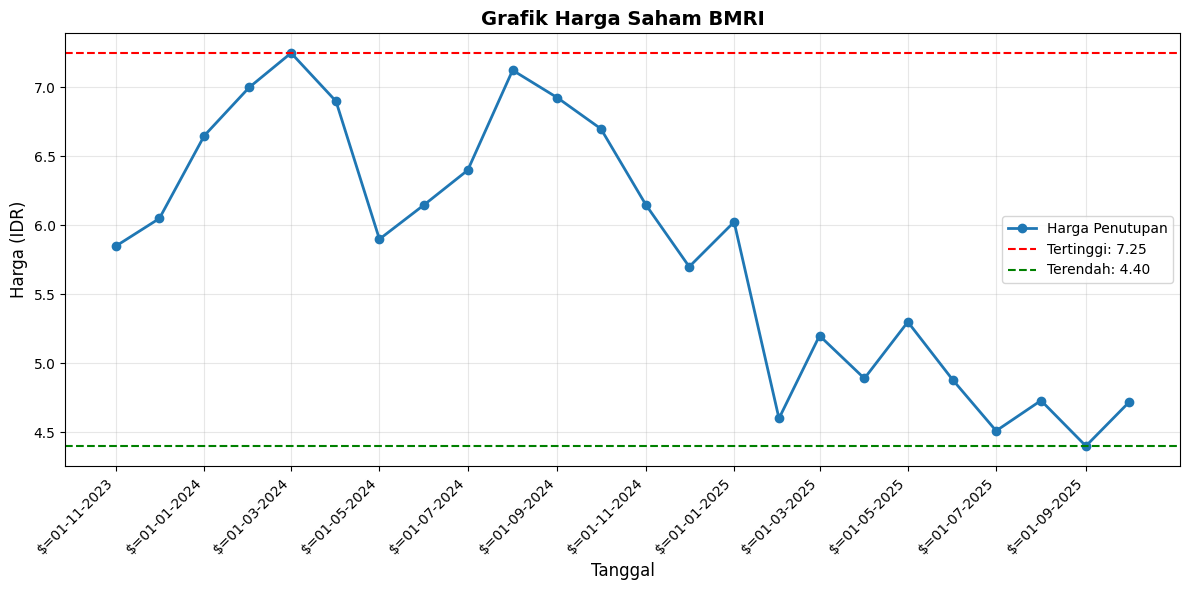

In [ ]:
# short Visualisasi harga penutupan saham
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Terakhir'], marker='o', linewidth=2,
      markersize=6, label='Harga Penutupan')
 
# Tambahkan garis harga tertinggi dan terendah
plt.axhline(y=df['Terakhir'].max(), color='red', linestyle=
      '--', label=f'Tertinggi: {df["Terakhir"].max():.2f}')
plt.axhline(y=df['Terakhir'].min(), color='green',
      linestyle='--', label=f'Terendah: {df["Terakhir"].min():.2f}')

# Format grafik
plt.title('Grafik Harga Saham BMRI', fontsize=14,
      fontweight='bold')
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga (IDR)', fontsize=12)
plt.xticks(df.index[::2], date_labels[::2], rotation=45, ha=
      'right', fontsize=10)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Feature Engineering

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Terakhir'].values.reshape(-1, 1))

In [ ]:
def create_sequences(data, sequence_length):
    X , y =[], []
    if len(data) <= sequence_length:
        print(f"data is too short (len={len(data)}) for sequence_length={sequence_length}")
        return np.array([]), np.array([])
    
    for i in range(sequence_length, len(data)):
        X.append(data[i - sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [ ]:
sequence_length = 6

# create all dataframe sequences
X, y = create_sequences(scaled_data, sequence_length)

# reshape to (samples, timestamps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# split data
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Model Building

In [ ]:
model = Sequential()

n_timesteps = X_train.shape[1]   # sequence_length
n_features  = X_train.shape[2] 

# First layer LSTM
model.add(Input(shape=(n_timesteps, n_features)))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

# second layer LSTM
#model.add(LSTM(units=50, return_sequences=False))
#model.add(Dropout(0.2))

# Dense Layer
model.add(Dense(units=16))
model.add(Dense(units=1))

model.summary()

model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=[
                  tf.keras.metrics.MeanAbsoluteError(name='mae'),
                  tf.keras.metrics.RootMeanSquaredError(name='rmse'),
                  tf.keras.metrics.MeanAbsolutePercentageError(name='mape')
              ])

2025-11-05 12:49:34.167551: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-11-05 12:49:34.167580: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-05 12:49:34.167583: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-11-05 12:49:34.167629: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-05 12:49:34.167653: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,897 (19.13 KB)

 Trainable params: 4,897 (19.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3, 
    min_lr=0.00001)

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=4,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100


2025-11-05 12:49:34.788982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 732ms/step - loss: 0.2737 - mae: 0.4643 - mape: 83.1001 - rmse: 0.5232 - val_loss: 0.0145 - val_mae: 0.0952 - val_mape: 38.1069 - val_rmse: 0.1203 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1595 - mae: 0.3517 - mape: 75.0138 - rmse: 0.3994 - val_loss: 0.0063 - val_mae: 0.0624 - val_mape: 25.0943 - val_rmse: 0.0796 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1220 - mae: 0.2899 - mape: 89.3484 - rmse: 0.3493 - val_loss: 0.0089 - val_mae: 0.0883 - val_mape: 46.7157 - val_rmse: 0.0946 - learning_rate: 0.0010
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0793 - mae: 0.2171 - mape: 87.6972 - rmse: 0.2817 - val_loss: 0.0210 - val_mae: 0.1186 - val_mape: 68.6757 - val_rmse: 0.1448 - learning_rate: 0.0010
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0778 - mae: 0.2279 - mape: 108.4151 - rmse: 0.2790 - val_loss: 0.0359 - val_mae: 0.1688 - val_mape: 93.7617 - v

Model Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# y_test_scaled for inverse transforming y_test
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_scaled, predictions))
mae = mean_squared_error(y_test_scaled, predictions)
mape = mean_absolute_percentage_error(y_test_scaled, predictions)
r2 = r2_score(y_test_scaled, predictions)

print(f'RMSE: {rmse:.2f} ')
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}%')
print(f'R² Score: {r2:.4f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
RMSE: 0.25 
MAE: 0.06
MAPE: 0.04%
R² Score: -2.2597


Preidction Future IHSG Price in 1 Month

In [ ]:
future_days = 30

last_30_days = df['Terakhir'].values[-sequence_length:].reshape(-1, 1)
last_30_days_scaled = scaler.transform(last_30_days)

future_predictions = []

for _ in range(future_days):
    X_predict = np.array([last_30_days_scaled])
    predicted_price = model.predict(X_predict)
    predicted_price_unscaled = scaler.inverse_transform(predicted_price)
    future_predictions.append(predicted_price_unscaled[0, 0])

    # Update window
    last_30_days_scaled = np.append(last_30_days_scaled[1:], predicted_price, axis=0)
    last_30_days_scaled = last_30_days_scaled.reshape(-1, 1)

# input from appended values into futture_predictions
future_predictions = np.array(future_predictions)

# padding predictions for balance predictions
pad_length = len(df) - len(predictions)
pred_padded = np.concatenate((np.full((pad_length, 1), np.nan), predictions))

# ensure index is datetime
if not np.issubdtype(df.index.dtype, np.datetime64):
    df['Tanggal'] = pd.to_datetime(df['Tanggal'], dayfirst=True, errors='coerce')
    df = df.set_index('Tanggal')

# create dataframe prediction result for forecasting
last_date = df.index[-1]
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1), 
    periods=future_days, freq='D')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

Visualitation IHSG Prediction

/var/folders/s0/01h8dy1902zgb59dr1yqy6jr0000gn/T/ipykernel_42222/4181688322.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.annotate(f'{float(predictions[i]):.2f}',
/var/folders/s0/01h8dy1902zgb59dr1yqy6jr0000gn/T/ipykernel_42222/4181688322.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xy=(df.index[-len(predictions):][i], float(predictions[i])),


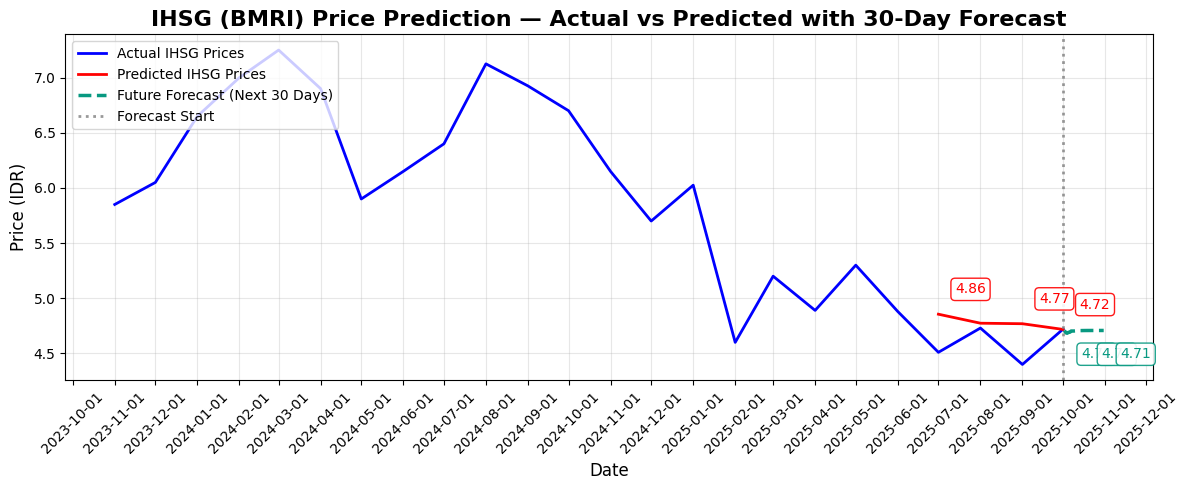

In [ ]:
plt.figure(figsize=(12, 5))

# Blue: actual data
plt.plot(df.index, df['Terakhir'], label='Actual IHSG Prices', color='blue', linewidth=2)

# Red: model prediction aligned with test data
pred_line = plt.plot(df.index[-len(predictions):], predictions, label='Predicted IHSG Prices', color='red', linewidth=2.0)

# Add minimal annotations to red prediction line (first, middle, and last points only)
pred_indices = [0, len(predictions)//2, len(predictions)-1] if len(predictions) > 1 else [0]
for i in pred_indices:
    if i < len(df.index[-len(predictions):]) and i < len(predictions):
        plt.annotate(f'{float(predictions[i]):.2f}', 
                    xy=(df.index[-len(predictions):][i], float(predictions[i])),
                    xytext=(12, 15), textcoords='offset points',
                    color='red', fontsize=10, ha='left',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, edgecolor='red'))

# Green: forecast (next 30 days after last data)
forecast_line = plt.plot(future_dates, future_predictions, label='Future Forecast (Next 30 Days)',
         color='#089981', linestyle='--', linewidth=2.5)

# Add minimal annotations to green forecast line (first, middle, and last points only)
forecast_indices = [0, len(future_predictions)//2, len(future_predictions)-1] if len(future_predictions) > 1 else [0]
for i in forecast_indices:
    if i < len(future_dates) and i < len(future_predictions):
        plt.annotate(f'{float(future_predictions[i]):.2f}', 
                    xy=(future_dates[i], float(future_predictions[i])),
                    xytext=(12, -20), textcoords='offset points',
                    color='#089981', fontsize=10, ha='left',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, edgecolor='#089981'))

# Forecast start line
plt.axvline(x=last_date, color='gray', linestyle=':', linewidth=2, alpha=0.8, label='Forecast Start')

plt.title('IHSG (BMRI) Price Prediction — Actual vs Predicted with 30-Day Forecast',
          fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (IDR)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()


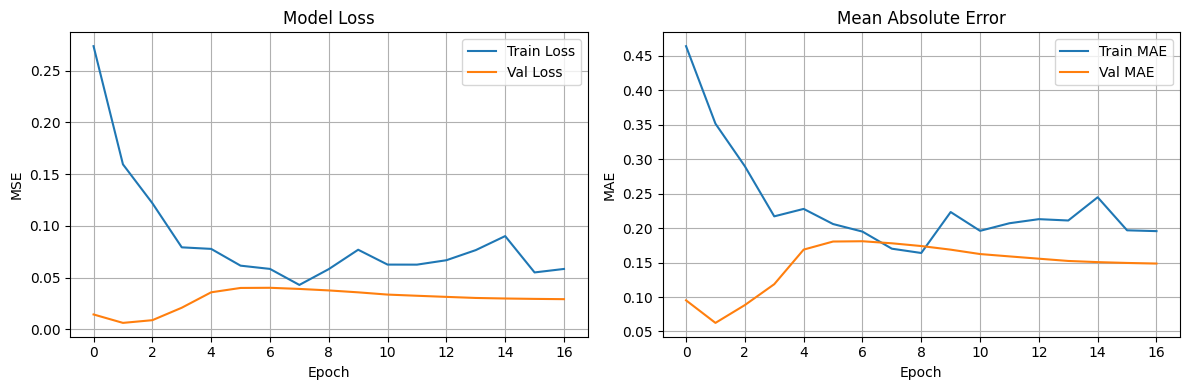

In [ ]:
# Training history visualization

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Transforming into DataFrame with pandas
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price IHSG': future_predictions
})

future_predictions_df.tail()

,Date,Predicted Price IHSG
25,2025-10-27,4.707934
26,2025-10-28,4.707942
27,2025-10-29,4.707946
28,2025-10-30,4.707950
29,2025-10-31,4.707953


In [ ]:
# calculate percentage change from the last actual close price
last_actual_price = df['Terakhir'].iloc[-1]
percentage_change = ((future_predictions_df['Predicted Price IHSG'].iloc[-1] - last_actual_price) / last_actual_price) * 100

# Determine profit or loss
status = "profit" if percentage_change > 0 else "loss"

# print the percentage prediction
print(f"Percentage prediction for 30 days is: {status} {abs(percentage_change):.2f}%")

Percentage prediction for 30 days is: loss 0.26%
